### Data Prepare

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [400]:
# Standard libs
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import geopandas as gpd
import geoplot
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)

from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib



In [401]:
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stops = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [402]:
# Input all raw data
customers_df = pd.read_csv('/content/drive/MyDrive/Final Project/E-Commerce Olist/olist_customers_dataset.csv')
location_df = pd.read_csv('/content/drive/MyDrive/Final Project/E-Commerce Olist/olist_geolocation_dataset.csv')
items_df = pd.read_csv('/content/drive/MyDrive/Final Project/E-Commerce Olist/olist_order_items_dataset.csv')
payments_df = pd.read_csv('/content/drive/MyDrive/Final Project/E-Commerce Olist/olist_order_payments_dataset.csv')
reviews_df = pd.read_csv('/content/drive/MyDrive/Final Project/E-Commerce Olist/olist_order_reviews_dataset.csv')
orders_df = pd.read_csv('/content/drive/MyDrive/Final Project/E-Commerce Olist/olist_orders_dataset.csv')
products_df = pd.read_csv('/content/drive/MyDrive/Final Project/E-Commerce Olist/olist_products_dataset.csv')
sellers_df = pd.read_csv('/content/drive/MyDrive/Final Project/E-Commerce Olist/olist_sellers_dataset.csv')
categories_df = pd.read_csv('/content/drive/MyDrive/Final Project/E-Commerce Olist/product_category_name_translation.csv')
eng_reviews_df = pd.read_csv('/content/drive/MyDrive/Final Project/E-Commerce Olist/Trans_en - trans.csv')

Overview Dataset

In [403]:
tables = [customers_df, sellers_df, reviews_df, items_df, products_df, location_df, categories_df, orders_df, payments_df]
titles = ["Customers", "Sellers", "Reviews", "Items", "Products", "Locations", "Category translation", "Orders", "Payments"]


# Creating an empty dataframe

data_summary = pd.DataFrame({})


# Filling data_summary with new columns

data_summary['Dataset']= titles
# data_summary['Columns'] = [', '.join([col for col, null in table.isnull().sum().items() ]) for table in tables] Other way
data_summary['Columns'] = [', '.join([col for col in table.columns.to_list() ]) for table in tables]
data_summary['Total_rows']= [table.shape[0] for table in tables]
data_summary['Total_cols']= [table.shape[1] for table in tables]
data_summary['Total_duplicate']= [len(table[table.duplicated()]) for table in tables]
data_summary['Total_null']= [table.isnull().sum().sum() for table in tables]
data_summary['Null_cols'] = [', '.join([col for col, null in table.isnull().sum().items() if null > 0]) for table in tables]

data_summary.style.background_gradient(cmap='Blues')

,Dataset,Columns,Total_rows,Total_cols,Total_duplicate,Total_null,Null_cols
0,Customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0,
1,Sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095,4,0,0,
2,Reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224,7,0,145903,"review_comment_title, review_comment_message"
3,Items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0,
4,Products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951,9,0,2448,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
5,Locations,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163,5,261831,0,
6,Category translation,"product_category_name, product_category_name_english",71,2,0,0,
7,Orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",99441,8,0,4908,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
8,Payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0,


#### Data Cleaning

##### Duplicate data

In [404]:
location_df[location_df.duplicated()]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
15,1046,-23.546081,-46.644820,sao paulo,SP
44,1046,-23.546081,-46.644820,sao paulo,SP
65,1046,-23.546081,-46.644820,sao paulo,SP
66,1009,-23.546935,-46.636588,sao paulo,SP
67,1046,-23.546081,-46.644820,sao paulo,SP
...,...,...,...,...,...
1000153,99970,-28.343273,-51.873734,ciriaco,RS
1000154,99950,-28.070493,-52.011342,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS


Duplicate data are zip code, the geolocation of the delivery points. This could be of value in estimating the density of delivery points so I decided to keep this dataset as it is

##### Unnecessary columns & Null values

In [405]:
# Removing unnecessary columns
products_df.drop(columns = ['product_name_lenght', 'product_description_lenght', 'product_photos_qty'], inplace=True, axis=1)

In [406]:
products_df.isna().sum()

product_id                 0
product_category_name    610
product_weight_g           2
product_length_cm          2
product_height_cm          2
product_width_cm           2
dtype: int64

In [407]:
# Replacing null values in product_weight_g column with the mean value

products_df['product_weight_g'].fillna(value = products_df['product_weight_g'].mean(), inplace = True)
products_df['product_length_cm'].fillna(value = products_df['product_length_cm'].mean(), inplace = True)
products_df['product_height_cm'].fillna(value = products_df['product_height_cm'].mean(), inplace = True)
products_df['product_width_cm'].fillna(value = products_df['product_width_cm'].mean(), inplace = True)

# Replacing null values in product_category_name column with 'Uncategorized'

products_df['product_category_name'].fillna(value = 'Uncategorized', inplace = True)

In [408]:
products_df.isna().sum()

product_id               0
product_category_name    0
product_weight_g         0
product_length_cm        0
product_height_cm        0
product_width_cm         0
dtype: int64

In [409]:
# Replacing null values in review column with Unknow
reviews_df['review_comment_title'].fillna(value = 'Unknow', inplace = True)
reviews_df['review_comment_message'].fillna(value = 'Unknow', inplace = True)

In [410]:
orders_df.tail()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00
99440,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03 00:00:00


In [411]:
orders_df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [412]:
orders_df[orders_df.isna().any(axis=1)]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaN,NaN,2018-02-06 00:00:00
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaN,NaN,2017-09-15 00:00:00


Create a table summarizing the number of Null values by order status

In [413]:
# Columns count null values
columns = ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']


# All order_status
status = orders_df['order_status'].unique()


# Creating an empty dataframe
data_summary = pd.DataFrame({})


# Filling data_summary with new columns
data_summary['Column']= columns
data_summary['Total_null']= [orders_df[column].isnull().sum().sum() for column in columns]
for s in status:
    data_summary[s] = [len(orders_df[(orders_df[column].isna() == True) & (orders_df['order_status'] == s)]) for column in columns]


# Setting a style for the background cells in gradient colors
data_summary.style.background_gradient(cmap='Blues', axis = 1)

,Column,Total_null,delivered,invoiced,shipped,processing,unavailable,canceled,created,approved
0,order_approved_at,160,14,0,0,0,0,141,5,0
1,order_delivered_carrier_date,1783,2,314,0,301,609,550,5,2
2,order_delivered_customer_date,2965,8,314,1107,301,609,619,5,2


Except Delivered, the remaining states can all contain Null values because the order is incomplete.

So I will decide to remove null values for orders with Delivered status

In [414]:
# Dropping orders with 'delivered' status that have null values in any date columns
orders_df.drop(orders_df[(orders_df.isna().any(axis=1)) & (orders_df['order_status'] == 'delivered')].index, inplace = True)

In [415]:
# Select rows that don't have null values using negate operator (~) on bool series and filtering to show only 'canceled' status
selected_rows = orders_df[~orders_df.isna().any(axis=1)][orders_df['order_status'] == 'canceled']


# Dropping selected rows in dataframe
orders_df.drop(selected_rows.index, inplace = True)

<ipython-input-415-7db8b0b043ed>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  selected_rows = orders_df[~orders_df.isna().any(axis=1)][orders_df['order_status'] == 'canceled']


In [416]:
# Columns I want to examine
columns = ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']


# All possible values of order_status
status = orders_df['order_status'].unique()


# Creating an empty dataframe
data_summary = pd.DataFrame({})


# Filling data_summary with new columns
data_summary['Column']= columns
data_summary['Total_null']= [orders_df[column].isnull().sum().sum() for column in columns]
for s in status:
    data_summary[s] = [len(orders_df[(orders_df[column].isna() == True) & (orders_df['order_status'] == s)]) for column in columns]


# Setting a style for the background cells in gradient colors
data_summary.style.background_gradient(cmap='Blues', axis = 1)

,Column,Total_null,delivered,invoiced,shipped,processing,unavailable,canceled,created,approved
0,order_approved_at,146,0,0,0,0,0,141,5,0
1,order_delivered_carrier_date,1781,0,314,0,301,609,550,5,2
2,order_delivered_customer_date,2957,0,314,1107,301,609,619,5,2


All 'delivered' orders that contained null values were successfully deleted.

Define function & plot the frequency of each order status

In [417]:
def single_countplot(df, ax, x = None, y = None, top = None, order = True, hue = False, palette = 'gist_earth',
                     width = 0.75, sub_width = 0.3, sub_size = 12):

    #Check plotting by breaking some categorical variables
    ncount = len(df)
    if x:
        col = x
    else:
        col = y

    #Plot top categorical variables
    if top is not None:
        cat_count = df[col].value_counts()
        top_categories = cat_count[:top].index
        df = df[df[col].isin(top_categories)]

    #Validate arguments and plotting graph
    if hue != False:
        if order:
            sns.countplot(x = x, y = y, data = df, palette = palette, ax = ax,
                          order = df[col].value_counts().index, hue = hue)
        else:
            sns.countplot(x = x, y = y, data = df, palette = palette, ax = ax, hue = hue)
    else:
        if order:
            sns.countplot(x = x, y = y, data = df, palette = palette, ax = ax, order = df[col].value_counts().index)
        else:
            sns.countplot(x = x, y = y, data = df, palette = palette, ax = ax)

    #Add percentage label
    if x:
        for p in ax.patches:
            x = p.get_bbox().get_points()[:, 0]
            y = p.get_bbox().get_points()[1, 1]
            ax.annotate('{}\n{:.1f}%'.format(int(y), 100. * y / ncount), (x.mean(), y), ha = 'center', va = 'bottom')
    else:
        for p in ax.patches:
            x = p.get_bbox().get_points()[1, 0]
            y = p.get_bbox().get_points()[:, 1]
            ax.annotate('{} ({:.1f}%)'.format(int(x), 100. * x / ncount), (x, y.mean()), va = 'center')

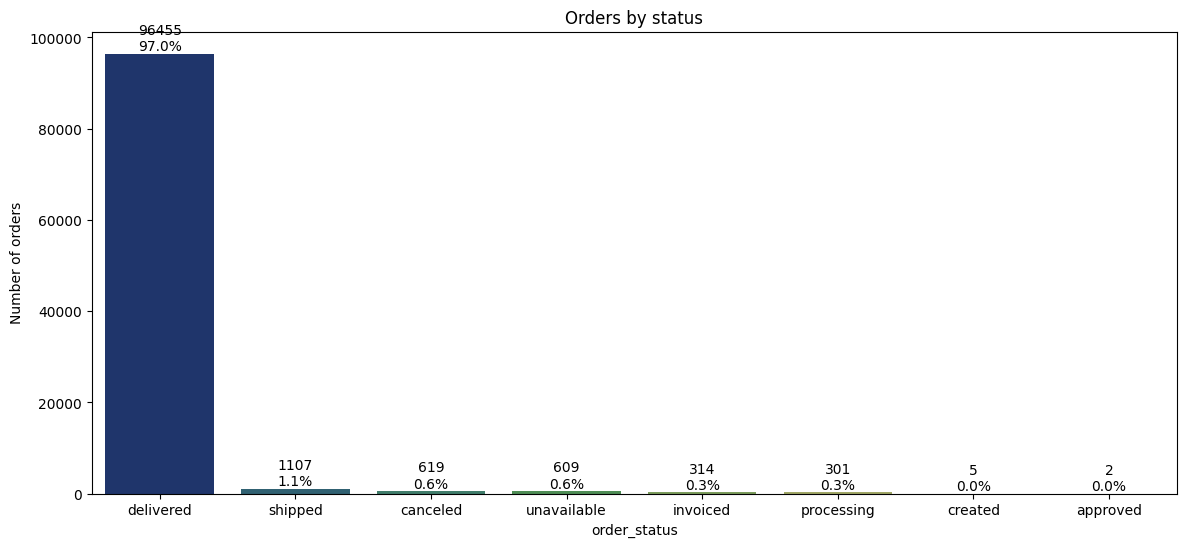

In [418]:
# Overview Order dataframe after clean
df_orders = orders_df.merge(customers_df, how='left', on='customer_id')
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(df_orders, x='order_status', ax=ax)
plt.title('Orders by status')
plt.ylabel('Number of orders')
plt.show()

#### Data preparation

In [419]:
# Add comment after convert to english
reviews_df['eng_comment'] = eng_reviews_df['eng_value']

In [420]:
reviews_df.describe()

,review_score
count,99224.000000
mean,4.086421
std,1.347579
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [421]:
reviews_df['eng_comment'].replace('in', 'Unknown', inplace=True)
reviews_df['eng_comment'].fillna('Unknown', inplace=True)

In [422]:
reviews_df.describe()

,review_score
count,99224.000000
mean,4.086421
std,1.347579
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


##### Merging dataframes

In [423]:
# Merging dataframes
df = orders_df.merge(items_df,on='order_id',how = 'left')
df = df.merge(payments_df, on='order_id',how = 'left')
df = df.merge(reviews_df, on='order_id',how = 'left')
df = df.merge(products_df, on='product_id',how = 'left')
df = df.merge(customers_df, on='customer_id',how = 'left')
df = df.merge(sellers_df, on='seller_id',how = 'left')
df = df.merge(categories_df, on='product_category_name',how = 'left')

In [424]:
df = df.drop('order_item_id',axis=1)
df = df[df['order_status'] == 'delivered']
df = df.drop_duplicates()

##### Check & fix datatype

In [425]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105284 entries, 0 to 119111
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       105284 non-null  object 
 1   customer_id                    105284 non-null  object 
 2   order_status                   105284 non-null  object 
 3   order_purchase_timestamp       105284 non-null  object 
 4   order_approved_at              105284 non-null  object 
 5   order_delivered_carrier_date   105284 non-null  object 
 6   order_delivered_customer_date  105284 non-null  object 
 7   order_estimated_delivery_date  105284 non-null  object 
 8   product_id                     105284 non-null  object 
 9   seller_id                      105284 non-null  object 
 10  shipping_limit_date            105284 non-null  object 
 11  price                          105284 non-null  float64
 12  freight_value                 

In [426]:
# Convert data type to datetime
time_col = ['order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date','order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date']
df[time_col] = df[time_col].apply(pd.to_datetime)

In [427]:
df['seller_zip_code_prefix'] = df['seller_zip_code_prefix'].astype(int)

In [428]:
# Recheck
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105284 entries, 0 to 119111
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       105284 non-null  object        
 1   customer_id                    105284 non-null  object        
 2   order_status                   105284 non-null  object        
 3   order_purchase_timestamp       105284 non-null  datetime64[ns]
 4   order_approved_at              105284 non-null  datetime64[ns]
 5   order_delivered_carrier_date   105284 non-null  datetime64[ns]
 6   order_delivered_customer_date  105284 non-null  datetime64[ns]
 7   order_estimated_delivery_date  105284 non-null  datetime64[ns]
 8   product_id                     105284 non-null  object        
 9   seller_id                      105284 non-null  object        
 10  shipping_limit_date            105284 non-null  datetime64[ns]
 11  

##### Feature Engineering

In [429]:
#Extract attributes on purchase date - (year and month)
df['order_purchase_year'] = df['order_purchase_timestamp'].apply(lambda x: x.year)
df['order_purchase_month'] = df['order_purchase_timestamp'].apply(lambda x: x.month)
df['order_purchase_month_name'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df['order_purchase_year_month'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df['order_purchase_date'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

#Extract attributes on purchase date - (day and day of week)
df['order_purchase_day'] = df['order_purchase_timestamp'].apply(lambda x: x.day)
df['order_purchase_dayofweek'] = df['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df['order_purchase_dayofweek_name'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))
df['order_purchase_year_month'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
#Extract attributes on purchase date - (hour and time of day)
df['order_purchase_hour'] = df['order_purchase_timestamp'].apply(lambda x: x.hour)

#Create hour bins and labels
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df['order_purchase_time_day'] = pd.cut(df['order_purchase_hour'], hours_bins, labels = hours_labels)
df = df.sort_values('order_purchase_timestamp')
# After September, the number of samples is very small => removes
df = df[(df['order_purchase_timestamp'] < '2018-09-01') & (df['order_purchase_timestamp'] > '2016-12-31')]

df.tail()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,eng_comment,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
119032,52018484704db3661b98ce838612b507,e450a297a7bc6839ceb0cf1a2377fa02,delivered,2018-08-29 12:25:59,2018-08-29 12:35:17,2018-08-29 13:38:00,2018-08-30 22:48:27,2018-09-03,777798445efd625458a90c13f3b3e6e7,5f2684dab12e59f83bef73ae57724e45,2018-08-31 12:35:17,63.90,9.20,1.0,credit_card,7.0,73.10,7a11bf826668febba0800ec35884958c,1.0,Muito frágil !!!,"Achei o produto muito pequeno e onde fica a ""t...",2018-08-31 00:00:00,2018-09-21 13:54:38,"I found the product very small and where the ""...",brinquedos,1500.0,28.0,22.0,18.0,7a22d14aa3c3599238509ddca4b93b01,5863,sao paulo,SP,5125,sao paulo,SP,toys,2018,8,Aug,201808,20180829,29,2,Wed,12,Morning
36049,0b223d92c27432930dfe407c6aea3041,e60df9449653a95af4549bbfcb18a6eb,delivered,2018-08-29 14:18:23,2018-08-29 14:31:07,2018-08-29 15:29:00,2018-08-30 16:24:55,2018-09-04,2b4472df15512a2825ae86fd9ae79335,67bf6941ba2f1fa1d02c375766bc3e53,2018-08-31 14:30:19,209.00,46.48,1.0,credit_card,8.0,510.96,6c50d16eb583d5db7e841b77e89b7045,5.0,Unknow,Unknow,2018-08-31 00:00:00,2018-10-24 16:27:36,Unknown,moveis_cozinha_area_de_servico_jantar_e_jardim,13550.0,48.0,49.0,49.0,5c58de6fb80e93396e2f35642666b693,80045,curitiba,PR,82400,curitiba,PR,kitchen_dining_laundry_garden_furniture,2018,8,Aug,201808,20180829,29,2,Wed,14,Afternoon
37803,168626408cb32af0ffaf76711caae1dc,6e353700bc7bcdf6ebc15d6de16d7002,delivered,2018-08-29 14:18:28,2018-08-29 14:30:23,2018-08-29 18:51:00,2018-08-30 16:52:31,2018-09-11,bdcf6a834e8faa30dac3886c7a58e92e,2a84855fd20af891be03bc5924d2b453,2018-08-31 14:30:23,45.90,15.39,1.0,voucher,1.0,61.29,39eae4e4d255222202c4255e8eee9084,5.0,Chegou rápido e correto,Recomendo,2018-08-31 00:00:00,2018-09-02 20:55:45,I recommend,beleza_saude,1614.0,31.0,16.0,28.0,7febafa06d9d8f232a900a2937f04338,38600,paracatu,MG,30111,belo horizonte,MG,health_beauty,2018,8,Aug,201808,20180829,29,2,Wed,14,Afternoon
83265,03ef5dedbe7492bdae72eec50764c43f,496630b6740bcca28fce9ba50d8a26ef,delivered,2018-08-29 14:52:00,2018-08-29 15:05:22,2018-08-29 20:01:00,2018-08-30 16:36:59,2018-09-03,c7f27c5bef2338541c772b5776403e6a,7d7866a99a8656a42c7ff6352a433410,2018-08-31 15:05:22,24.90,8.33,1.0,credit_card,1.0,33.23,8a8ebb5019795478156fa952acd050b1,3.0,Recomendo,Unknow,2018-08-31 00:00:00,2018-08-31 20:02:48,Unknown,artigos_de_festas,450.0,28.0,9.0,19.0,b701bebbdf478f5500348f03aff62121,9541,sao caetano do sul,SP,1320,sao paulo,SP,party_supplies,2018,8,Aug,201808,20180829,29,2,Wed,14,Afternoon
105367,35a972d7f8436f405b56e36add1a7140,898b7fee99c4e42170ab69ba59be0a8b,delivered,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-08-29 16:57:00,2018-08-30 16:23:36,2018-09-05,d04857e7b4b708ee8b8b9921163edba3,9f505651f4a6abe901a56cdc21508025,2018-08-31 15:10:26,84.99,8.76,1.0,credit_card,1.0,93.75,390c8570648658f80968ae6f77142429,5.0,Unknow,Unknow,2018-08-31 00:00:00,2018-09-09 16:49:27,Unknown,informatica_acessorios,450.0,16.0,4.0,20.0,24ac2b4327e25baf39f2119e4228976a,13483,limeira,SP,4102,sao paulo,SP,computers_accessories,2018,8,Aug,201808,20180829,29,2,Wed,15,Afternoon


In [430]:
# Calculate the time between events related to orders
df['payment_time'] = df['order_approved_at'] - df['order_purchase_timestamp'].copy()
df['carrier_time'] = df['order_delivered_carrier_date'] - df['order_approved_at'].copy()
df['delivery_time_estimate'] = df['order_estimated_delivery_date'] - df['order_delivered_carrier_date'].copy()
df['delivery_time_actual'] = df['order_delivered_customer_date'] - df['order_delivered_carrier_date'].copy()
df['delay_time'] = df['delivery_time_actual'] - df['delivery_time_estimate'].copy()


<ipython-input-430-745a274db5f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['payment_time'] = df['order_approved_at'] - df['order_purchase_timestamp'].copy()
<ipython-input-430-745a274db5f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['carrier_time'] = df['order_delivered_carrier_date'] - df['order_approved_at'].copy()
<ipython-input-430-745a274db5f3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [431]:
# Function converts a timedelta object to the equivalent number of days
def convert_diff_days(x):
  return round((x.days + x.seconds/(3600*24)),2)

In [432]:
# Apply above function
df['payment_time'] = df['payment_time'].apply(convert_diff_days)
df['carrier_time'] = df['carrier_time'].apply(convert_diff_days)
df['delivery_time_estimate'] = df['delivery_time_estimate'].apply(convert_diff_days)
df['delivery_time_actual'] = df['delivery_time_actual'].apply(convert_diff_days)
df['delay_time'] = df['delay_time'].apply(convert_diff_days)

In [433]:
# Creat total time columns
df['total_time'] = df['payment_time'] + df['carrier_time'] + df['delivery_time_actual']

In [434]:
# Set 'on_time_delivery' to 1 for orders that were delivered on time.
df['on_time_delivery'] = 1
# For orders with a delivery delay, set 'on_time_delivery' to 0.
df.loc[df['delay_time'] > 0,'on_time_delivery'] = 0

In [435]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,eng_comment,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,payment_time,carrier_time,delivery_time_estimate,delivery_time_actual,delay_time,total_time,on_time_delivery
94178,ec7a019261fce44180373d45b442d78f,c24fc5f9a446b4d8262041b9c64de772,delivered,2017-01-05 11:56:06,2017-01-05 12:10:17,2017-01-06 12:43:41,2017-01-11 13:14:05,2017-02-01,f5d8f4fbc70ca2a0038b9a0010ed5cb0,48efc9d94a9834137efd9ea76b065a38,2017-01-09 11:56:06,10.9,8.72,1.0,credit_card,1.0,19.62,5f45d6aa32336fa26cbc254721c81880,5.0,Unknow,Adorei o produto! Super recomendo o lojista. R...,2017-01-12 00:00:00,2017-01-13 20:22:46,I loved the product! I highly recommend the sh...,fashion_bolsas_e_acessorios,200.0,16.0,2.0,11.0,f7b981e8a280e455ac3cbe0d5d171bd1,80030,curitiba,PR,81130,curitiba,PR,fashion_bags_accessories,2017,1,Jan,201701,20170105,5,3,Thu,11,Morning,0.01,1.02,25.47,5.02,-20.45,6.05,1
19298,b95a0a8bd30aece4e94e81f0591249d8,ff3c6d35b4927c9b965aa6a68dcf56e4,delivered,2017-01-05 12:01:20,2017-01-07 03:35:37,2017-01-11 16:22:53,2017-01-17 15:38:58,2017-02-13,6c04a068e5ab37749c980c42a036b9e3,48efc9d94a9834137efd9ea76b065a38,2017-01-09 12:01:20,10.9,8.72,1.0,boleto,1.0,19.62,4e9bc73d2795d85dc2e8b7dbb99e304c,5.0,Unknow,"Adorei o produto, condiz com as imagens, a ent...",2017-01-18 00:00:00,2017-01-18 10:56:46,"I loved the product, it matches the pictures, ...",automotivo,200.0,16.0,2.0,11.0,83e7958a94bd7f74a9414d8782f87628,80030,curitiba,PR,81130,curitiba,PR,auto,2017,1,Jan,201701,20170105,5,3,Thu,12,Morning,1.65,4.53,32.32,5.97,-26.35,12.15,1
89286,38bcb524e1c38c2c1b60600a80fc8999,d2c63ad286e3ca9dd69218008d61ff81,delivered,2017-01-05 12:06:36,2017-01-07 03:45:22,2017-01-11 15:35:54,2017-01-16 16:05:22,2017-02-13,680cc8535be7cc69544238c1d6a83fe8,48efc9d94a9834137efd9ea76b065a38,2017-01-09 12:06:36,2.9,8.72,1.0,boleto,1.0,11.62,e48def6468ee7a31da5dc7249487304c,5.0,Unknow,Loja entregou no prazo sem qualquer problema. ...,2017-01-17 00:00:00,2017-01-18 11:51:43,Store delivered on time without any problem. P...,pet_shop,200.0,16.0,2.0,11.0,728e4a7d0db4845270091ded0923c71f,80540,curitiba,PR,81130,curitiba,PR,pet_shop,2017,1,Jan,201701,20170105,5,3,Thu,12,Morning,1.65,4.49,32.35,5.02,-27.33,11.16,1
18264,7a18a504c1a4b32d883e68de2e1a7db0,e6bee29442c761ff0dfb9a4414922a5c,delivered,2017-01-05 12:09:08,2017-01-07 03:44:08,2017-01-11 15:35:53,2017-01-16 15:43:29,2017-02-13,c0d4027067afcf9c1697cce981b8fed6,48efc9d94a9834137efd9ea76b065a38,2017-01-09 12:09:08,7.9,8.72,1.0,boleto,1.0,16.62,ef0cb49c494b34d55782e4c91bdc8730,5.0,Unknow,Adorei a embalagem e o atendimento. Produto ma...,2017-01-17 00:00:00,2017-01-18 11:54:40,I loved the packaging and the service. Wonderf...,pet_shop,200.0,16.0,2.0,11.0,728e4a7d0db4845270091ded0923c71f,80540,curitiba,PR,81130,curitiba,PR,pet_shop,2017,1,Jan,201701,20170105,5,3,Thu,12,Morning,1.65,4.49,32.35,5.01,-27.34,11.15,1
32341,6acecf438369055d9243e121045cca74,42d857e22f61f10476f0cda1aacc018a,delivered,2017-01-05 12:11:23,2017-01-07 03:44:07,2017-01-11 16:22:53,2017-01-17 16:06:30,2017-02-13,1514ddb0f4a5afc8d24104e89c714403,48efc9d94a9834137efd9ea76b065a38,2017-01-09 12:11:23,9.9,8.72,1.0,boleto,1.0,18.62,ca514a4c482df7a74f

Calculate delivery distance for each order

In [436]:
location_df.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [437]:
location_tb = location_df.groupby('geolocation_zip_code_prefix')[['geolocation_lat','geolocation_lng']].mean().reset_index()
location_tb

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1001,-23.550190,-46.634024
1,1002,-23.548146,-46.634979
2,1003,-23.548994,-46.635731
3,1004,-23.549799,-46.634757
4,1005,-23.549456,-46.636733
...,...,...,...
19010,99960,-27.953722,-52.025511
19011,99965,-28.183372,-52.039850
19012,99970,-28.343766,-51.874689
19013,99980,-28.389129,-51.843836


In [438]:
# Get zip_code
list_code = location_tb['geolocation_zip_code_prefix'].to_list()
list_seller_code = df['seller_zip_code_prefix'].to_list()
list_customer_code = df['customer_zip_code_prefix'].to_list()
set_code = set(list_code)
set_seller_code = set(list_seller_code)
set_customer_code = set(list_customer_code)

In [439]:
# This function creates a dictionary mapping zip code prefixes to their corresponding latitude and longitude coordinates.
def get_code(data):
  key_columns = data['geolocation_zip_code_prefix']
  value_columns1 = data['geolocation_lat']
  value_columns2 = data['geolocation_lng']
  my_dict = dict(zip(key_columns,zip(value_columns1,value_columns2)))
  return my_dict
code_coordinates = get_code(location_tb)

In [440]:
# Check len
len(code_coordinates)

19015

In [441]:
# Find the set of seller codes that are not in the set of general codes.
diff_seller_code = set_seller_code - set_code

# Find the set of customer codes that are not in the set of general codes.
diff_customer_code = set_customer_code - set_code

# Combine the sets of seller and customer codes that are not in the general set.
diff_code = diff_seller_code.union(diff_customer_code)


In [442]:
# For each code in 'diff_code', find the closest matching code in 'code_coordinates'and assign its corresponding coordinates to the original code.
for key in diff_code:
    closest_key = min(code_coordinates.keys(), key=lambda x: abs(x - key))
    code_coordinates[key] = code_coordinates[closest_key]


In [443]:
# Check len again
len(code_coordinates)

19172

In [444]:
from geopy.distance import geodesic
# The function 'calculate_distance' that calculates the geographical distance
def calculate_distance(row):
    seller_code = row['seller_zip_code_prefix']
    customer_code = row['customer_zip_code_prefix']

    if seller_code in code_coordinates and customer_code in code_coordinates:
        seller_coordinates = code_coordinates[seller_code]
        customer_coordinates = code_coordinates[customer_code]
        distance_km = geodesic(seller_coordinates, customer_coordinates).kilometers
        return distance_km
    else:
        return None

In [445]:
# Apply the 'calculate_distance' function
df['distance'] = df.apply(calculate_distance, axis=1)

In [446]:
# Assign distance groups based on specific thresholds
df.loc[:,'distance_group'] = 1
df.loc[df['distance'] > 300,'distance_group'] = 2
df.loc[df['distance'] > 1000,'distance_group'] = 3

In [447]:
df.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,eng_comment,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,payment_time,carrier_time,delivery_time_estimate,delivery_time_actual,delay_time,total_time,on_time_delivery,distance,distance_group
94178,ec7a019261fce44180373d45b442d78f,c24fc5f9a446b4d8262041b9c64de772,delivered,2017-01-05 11:56:06,2017-01-05 12:10:17,2017-01-06 12:43:41,2017-01-11 13:14:05,2017-02-01,f5d8f4fbc70ca2a0038b9a0010ed5cb0,48efc9d94a9834137efd9ea76b065a38,2017-01-09 11:56:06,10.9,8.72,1.0,credit_card,1.0,19.62,5f45d6aa32336fa26cbc254721c81880,5.0,Unknow,Adorei o produto! Super recomendo o lojista. R...,2017-01-12 00:00:00,2017-01-13 20:22:46,I loved the product! I highly recommend the sh...,fashion_bolsas_e_acessorios,200.0,16.0,2.0,11.0,f7b981e8a280e455ac3cbe0d5d171bd1,80030,curitiba,PR,81130,curitiba,PR,fashion_bags_accessories,2017,1,Jan,201701,20170105,5,3,Thu,11,Morning,0.01,1.02,25.47,5.02,-20.45,6.05,1,10.505629,1
19298,b95a0a8bd30aece4e94e81f0591249d8,ff3c6d35b4927c9b965aa6a68dcf56e4,delivered,2017-01-05 12:01:20,2017-01-07 03:35:37,2017-01-11 16:22:53,2017-01-17 15:38:58,2017-02-13,6c04a068e5ab37749c980c42a036b9e3,48efc9d94a9834137efd9ea76b065a38,2017-01-09 12:01:20,10.9,8.72,1.0,boleto,1.0,19.62,4e9bc73d2795d85dc2e8b7dbb99e304c,5.0,Unknow,"Adorei o produto, condiz com as imagens, a ent...",2017-01-18 00:00:00,2017-01-18 10:56:46,"I loved the product, it matches the pictures, ...",automotivo,200.0,16.0,2.0,11.0,83e7958a94bd7f74a9414d8782f87628,80030,curitiba,PR,81130,curitiba,PR,auto,2017,1,Jan,201701,20170105,5,3,Thu,12,Morning,1.65,4.53,32.32,5.97,-26.35,12.15,1,10.505629,1
89286,38bcb524e1c38c2c1b60600a80fc8999,d2c63ad286e3ca9dd69218008d61ff81,delivered,2017-01-05 12:06:36,2017-01-07 03:45:22,2017-01-11 15:35:54,2017-01-16 16:05:22,2017-02-13,680cc8535be7cc69544238c1d6a83fe8,48efc9d94a9834137efd9ea76b065a38,2017-01-09 12:06:36,2.9,8.72,1.0,boleto,1.0,11.62,e48def6468ee7a31da5dc7249487304c,5.0,Unknow,Loja entregou no prazo sem qualquer problema. ...,2017-01-17 00:00:00,2017-01-18 11:51:43,Store delivered on time without any problem. P...,pet_shop,200.0,16.0,2.0,11.0,728e4a7d0db4845270091ded0923c71f,80540,curitiba,PR,81130,curitiba,PR,pet_shop,2017,1,Jan,201701,20170105,5,3,Thu,12,Morning,1.65,4.49,32.35,5.02,-27.33,11.16,1,11.625812,1
18264,7a18a504c1a4b32d883e68de2e1a7db0,e6bee29442c761ff0dfb9a4414922a5c,delivered,2017-01-05 12:09:08,2017-01-07 03:44:08,2017-01-11 15:35:53,2017-01-16 15:43:29,2017-02-13,c0d4027067afcf9c1697cce981b8fed6,48efc9d94a9834137efd9ea76b065a38,2017-01-09 12:09:08,7.9,8.72,1.0,boleto,1.0,16.62,ef0cb49c494b34d55782e4c91bdc8730,5.0,Unknow,Adorei a embalagem e o atendimento. Produto ma...,2017-01-17 00:00:00,2017-01-18 11:54:40,I loved the packaging and the service. Wonderf...,pet_shop,200.0,16.0,2.0,11.0,728e4a7d0db4845270091ded0923c71f,80540,curitiba,PR,81130,curitiba,PR,pet_shop,2017,1,Jan,201701,20170105,5,3,Thu,12,Morning,1.65,4.49,32.35,5.01,-27.34,11.15,1,11.625812,1
32341,6acecf438369055d9243e121045cca74,42d857e22f61f10476f0cda1aacc018a,delivered,2017-01-05 12:11:23,2017-01-07 03:44:07,2017-01-11 16:22:53,2017-01-17 16:06:30,2017-02-13,1514ddb0f4a5afc8d24104e89c714403,48efc9d94a9834137efd9ea76b065

In [448]:
df.describe()

,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_zip_code_prefix,seller_zip_code_prefix,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,payment_time,carrier_time,delivery_time_estimate,delivery_time_actual,delay_time,total_time,on_time_delivery,distance,distance_group
count,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000,104262.000000,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000,104984.000000
mean,123.586756,20.101686,1.091147,2.894251,156.518401,4.123765,2100.934338,30.164498,16.382305,23.100335,35067.652899,24571.696535,2017.543454,6.026337,15.545521,2.757915,14.787377,0.423877,2.767096,20.540286,9.301746,-11.238549,12.492719,0.920636,599.362764,1.834718
std,188.088033,15.817798,0.673361,2.724073,216.919574,1.311948,3770.403982,16.074491,13.282351,11.771097,29787.066765,27628.473820,0.498111,3.226118,8.664354,1.966263,5.341707,0.850776,3.428000,8.685392,8.760440,10.129660,9.513791,0.270308,588.759608,0.675022
min,0.850000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1003.000000,1001.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-171.220000,-99.660000,-16.100000,-146.020000,0.540000,0.000000,0.000000,1.000000
25%,40.000000,13.140000,1.000000,1.000000,57.687500,4.000000,300.000000,18.000000,8.000000,15.000000,11320.000000,6506.000000,2017.000000,3.000000,8.000000,1.000000,11.000000,0.010000,0.880000,15.010000,4.090000,-16.270000,6.740000,1.000000,191.013988,1.000000
50%,78.000000,16.330000,1.000000,1.000000,102.060000,5.000000,700.000000,25.000000,13.000000,20.000000,24358.000000,13660.000000,2018.000000,6.000000,16.000000,3.000000,15.000000,0.010000,1.810000,20.290000,7.090000,-12.040000,10.190000,1.000000,434.861461,2.000000
75%,138.000000,21.210000,1.000000,4.000000,175.770000,5.000000,1800.000000,38.000000,20.000000,30.000000,58428.000000,29107.000000,2018.000000,8.000000,23.000000,4.000000,19.000000,0.590000,3.540000,25.610000,12.010000,-6.470000,15.550000,1.000000,797.488545,2.000000
max,6735.000000,409.680000,26.000000,24.000000,13664.080000,5.000000,40425.000000,105.000000,105.000000,118.000000,99980.000000,99730.000000,2018.000000,12.000000,31.000000,6.000000,23.000000,30.890000,125.760000,192.430000,205.190000,188.980000,209.630000,1.000000,8652.119722,3.000000


In [449]:
# Remove Outlier
df = df[df['delivery_time_actual'] > 0]
df = df[df['delivery_time_estimate'] > 0]
df = df[df['carrier_time'] > -2]

In [450]:
df.describe()

,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_zip_code_prefix,seller_zip_code_prefix,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,payment_time,carrier_time,delivery_time_estimate,delivery_time_actual,delay_time,total_time,on_time_delivery,distance,distance_group
count,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000,103538.000000,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000,104246.000000
mean,123.322663,20.111290,1.090958,2.895440,156.274096,4.132830,2097.991208,30.164886,16.375697,23.092479,35136.976747,24584.690684,2017.542774,6.021814,15.548146,2.758984,14.787694,0.413231,2.695449,20.660313,9.323782,-11.336537,12.432462,0.924736,600.722557,1.836627
std,187.065765,15.813649,0.672700,2.723923,216.084744,1.303838,3764.847034,16.073585,13.284562,11.769556,29790.491870,27627.126568,0.498169,3.227954,8.658532,1.965679,5.343111,0.809829,2.998035,8.484516,8.740430,9.994950,9.398646,0.263819,589.001048,0.674630
min,0.850000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1003.000000,1001.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-1.980000,0.010000,0.030000,-146.020000,0.540000,0.000000,0.000000,1.000000
25%,40.000000,13.160000,1.000000,1.000000,57.690000,4.000000,300.000000,18.000000,8.000000,15.000000,11390.000000,6506.000000,2017.000000,3.000000,8.000000,1.000000,11.000000,0.010000,0.880000,15.090000,4.110000,-16.290000,6.730000,1.000000,194.769166,1.000000
50%,78.000000,16.350000,1.000000,1.000000,102.030000,5.000000,700.000000,25.000000,13.000000,20.000000,24431.000000,13660.000000,2018.000000,6.000000,16.000000,3.000000,15.000000,0.010000,1.810000,20.310000,7.100000,-12.070000,10.180000,1.000000,436.113768,2.000000
75%,138.000000,21.207500,1.000000,4.000000,175.640000,5.000000,1800.000000,38.000000,20.000000,30.000000,58753.750000,29156.000000,2018.000000,8.000000,23.000000,4.000000,19.000000,0.580000,3.510000,25.690000,12.020000,-6.600000,15.460000,1.000000,798.769752,2.000000
max,6735.000000,409.680000,26.000000,24.000000,13664.080000,5.000000,40425.000000,105.000000,105.000000,118.000000,99980.000000,99730.000000,2018.000000,12.000000,31.000000,6.000000,23.000000,30.890000,47.500000,148.100000,205.190000,188.980000,209.630000,1.000000,8652.119722,3.000000


### EDA

#### Big Question : What product categories should new sellers start on Olist with?

Target Audience : New Seller

Metric : Review Score

In [451]:
# Create a copy of the original DataFrame 'df' to start the analysis.
final_df = df.copy()

In [452]:
final_df.head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,eng_comment,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,payment_time,carrier_time,delivery_time_estimate,delivery_time_actual,delay_time,total_time,on_time_delivery,distance,distance_group
94178,ec7a019261fce44180373d45b442d78f,c24fc5f9a446b4d8262041b9c64de772,delivered,2017-01-05 11:56:06,2017-01-05 12:10:17,2017-01-06 12:43:41,2017-01-11 13:14:05,2017-02-01,f5d8f4fbc70ca2a0038b9a0010ed5cb0,48efc9d94a9834137efd9ea76b065a38,2017-01-09 11:56:06,10.9,8.72,1.0,credit_card,1.0,19.62,5f45d6aa32336fa26cbc254721c81880,5.0,Unknow,Adorei o produto! Super recomendo o lojista. R...,2017-01-12 00:00:00,2017-01-13 20:22:46,I loved the product! I highly recommend the sh...,fashion_bolsas_e_acessorios,200.0,16.0,2.0,11.0,f7b981e8a280e455ac3cbe0d5d171bd1,80030,curitiba,PR,81130,curitiba,PR,fashion_bags_accessories,2017,1,Jan,201701,20170105,5,3,Thu,11,Morning,0.01,1.02,25.47,5.02,-20.45,6.05,1,10.505629,1
19298,b95a0a8bd30aece4e94e81f0591249d8,ff3c6d35b4927c9b965aa6a68dcf56e4,delivered,2017-01-05 12:01:20,2017-01-07 03:35:37,2017-01-11 16:22:53,2017-01-17 15:38:58,2017-02-13,6c04a068e5ab37749c980c42a036b9e3,48efc9d94a9834137efd9ea76b065a38,2017-01-09 12:01:20,10.9,8.72,1.0,boleto,1.0,19.62,4e9bc73d2795d85dc2e8b7dbb99e304c,5.0,Unknow,"Adorei o produto, condiz com as imagens, a ent...",2017-01-18 00:00:00,2017-01-18 10:56:46,"I loved the product, it matches the pictures, ...",automotivo,200.0,16.0,2.0,11.0,83e7958a94bd7f74a9414d8782f87628,80030,curitiba,PR,81130,curitiba,PR,auto,2017,1,Jan,201701,20170105,5,3,Thu,12,Morning,1.65,4.53,32.32,5.97,-26.35,12.15,1,10.505629,1
89286,38bcb524e1c38c2c1b60600a80fc8999,d2c63ad286e3ca9dd69218008d61ff81,delivered,2017-01-05 12:06:36,2017-01-07 03:45:22,2017-01-11 15:35:54,2017-01-16 16:05:22,2017-02-13,680cc8535be7cc69544238c1d6a83fe8,48efc9d94a9834137efd9ea76b065a38,2017-01-09 12:06:36,2.9,8.72,1.0,boleto,1.0,11.62,e48def6468ee7a31da5dc7249487304c,5.0,Unknow,Loja entregou no prazo sem qualquer problema. ...,2017-01-17 00:00:00,2017-01-18 11:51:43,Store delivered on time without any problem. P...,pet_shop,200.0,16.0,2.0,11.0,728e4a7d0db4845270091ded0923c71f,80540,curitiba,PR,81130,curitiba,PR,pet_shop,2017,1,Jan,201701,20170105,5,3,Thu,12,Morning,1.65,4.49,32.35,5.02,-27.33,11.16,1,11.625812,1
18264,7a18a504c1a4b32d883e68de2e1a7db0,e6bee29442c761ff0dfb9a4414922a5c,delivered,2017-01-05 12:09:08,2017-01-07 03:44:08,2017-01-11 15:35:53,2017-01-16 15:43:29,2017-02-13,c0d4027067afcf9c1697cce981b8fed6,48efc9d94a9834137efd9ea76b065a38,2017-01-09 12:09:08,7.9,8.72,1.0,boleto,1.0,16.62,ef0cb49c494b34d55782e4c91bdc8730,5.0,Unknow,Adorei a embalagem e o atendimento. Produto ma...,2017-01-17 00:00:00,2017-01-18 11:54:40,I loved the packaging and the service. Wonderf...,pet_shop,200.0,16.0,2.0,11.0,728e4a7d0db4845270091ded0923c71f,80540,curitiba,PR,81130,curitiba,PR,pet_shop,2017,1,Jan,201701,20170105,5,3,Thu,12,Morning,1.65,4.49,32.35,5.01,-27.34,11.15,1,11.625812,1
32341,6acecf438369055d9243e121045cca74,42d857e22f61f10476f0cda1aacc018a,delivered,2017-01-05 12:11:23,2017-01-07 03:44:07,2017-01-11 16:22:53,2017-01-17 16:06:30,2017-02-13,1514ddb0f4a5afc8d24104e89c714403,48efc9d94a9834137efd9ea76b065

##### Priority Product Category Suggestion






###### Business aspect

In [453]:
revenue_prod = final_df.groupby('product_category_name_english')['payment_value'].sum().reset_index().sort_values('payment_value', ascending=False)
revenue_prod['payment_value'] = round(revenue_prod['payment_value']/1000,2)
revenue_prod['percentage'] = revenue_prod['payment_value']/ final_df[~final_df['product_category_name_english'].isna()]['payment_value'].sum()*100000
revenue_prod['cumsum'] = revenue_prod['percentage'].cumsum()
revenue_prod['rank'] = range(1, len(revenue_prod) + 1)
revenue_prod.head(20)

,product_category_name_english,payment_value,percentage,cumsum,rank
43,health_beauty,1453.70,9.039355,9.039355,1
7,bed_bath_table,1446.26,8.993092,18.032446,2
70,watches_gifts,1297.00,8.064967,26.097414,3
65,sports_leisure,1164.61,7.241744,33.339157,4
15,computers_accessories,1123.39,6.985431,40.324588,5
39,furniture_decor,986.47,6.134039,46.458627,6
49,housewares,797.91,4.961541,51.420168,7
20,cool_stuff,698.48,4.343268,55.763435,8
5,auto,681.95,4.240482,60.003917,9
42,garden_tools,603.06,3.749930,63.753847,10


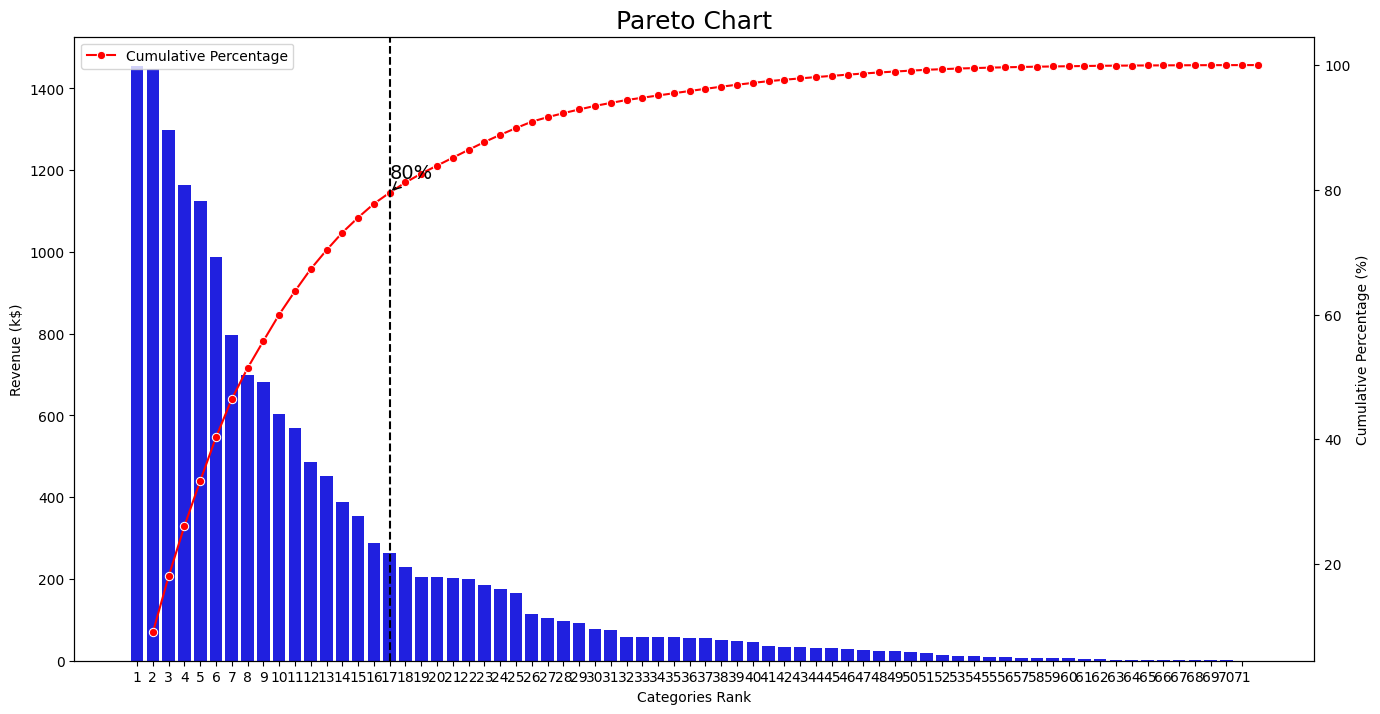

In [454]:
fig, ax1 = plt.subplots(figsize=(16,8))

sns.barplot(data=revenue_prod, x=revenue_prod['rank'], y=revenue_prod['payment_value'], ax= ax1,color='blue',label='Revenue')
ax1.set_xlabel('Categories Rank')
ax1.set_ylabel('Revenue (k$)')

ax2= ax1.twinx()
sns.lineplot(data=revenue_prod, x=revenue_prod['rank'], y=revenue_prod['cumsum'],ax=ax2,color='red', marker='o',label='Cumulative Percentage')
ax2.set_ylabel('Cumulative Percentage (%)')
ax2.axvline(x=16, color='black', linestyle='--')
ax2.annotate(f'{revenue_prod["cumsum"].iloc[15]:.0f}%', xy=(16, revenue_prod["cumsum"].iloc[15]), xycoords='data', textcoords='offset points', arrowprops=dict(arrowstyle="->"), xytext=(0, 10),fontsize=14)

plt.title('Pareto Chart',fontsize=18)
plt.subplots_adjust(bottom=0.1)
plt.xticks(rotation=90)
plt.show()

* 20% of the categories (16) account for 80% of the total revenue.
* I will choose top 10 priority product categories from this 20%.

In [455]:
top_prod = revenue_prod[revenue_prod['rank'] < 11]['product_category_name_english'].to_list()
top_prod

['health_beauty',
 'bed_bath_table',
 'watches_gifts',
 'sports_leisure',
 'computers_accessories',
 'furniture_decor',
 'housewares',
 'cool_stuff',
 'auto',
 'garden_tools']

In [456]:
final_df = final_df[final_df['product_category_name_english'].isin(top_prod)]

###### Customer experience.

In [457]:
category_tb = final_df.groupby('product_category_name_english').agg({'seller_id':'nunique','order_id':'count','payment_value':'sum','review_score': 'mean','freight_value': 'mean','delivery_time_actual': 'mean'}).reset_index()
category_tb['sales_per_seller'] = round(category_tb['payment_value']/ category_tb['seller_id'],2)
category_tb['revenue_per_prod'] = round(category_tb['payment_value']/ category_tb['order_id'],2)
category_tb

,product_category_name_english,seller_id,order_id,payment_value,review_score,freight_value,delivery_time_actual,sales_per_seller,revenue_per_prod
0,auto,364,4022,681952.99,4.141179,21.686228,9.379848,1873.50,169.56
1,bed_bath_table,187,10712,1446264.89,3.944617,18.449722,9.744388,7734.04,135.01
2,computers_accessories,277,6950,1123385.25,4.066647,19.066626,9.617403,4055.54,161.64
3,cool_stuff,256,3747,698483.07,4.217321,21.919901,9.496475,2728.45,186.41
4,furniture_decor,336,6904,986471.85,4.045123,21.363384,9.347751,2935.93,142.88
5,garden_tools,226,3707,603055.89,4.167436,23.660429,10.622293,2668.39,162.68
6,health_beauty,472,9030,1453697.41,4.230350,19.201868,9.061508,3079.87,160.99
7,housewares,449,6182,797914.83,4.196551,21.495304,8.123709,1777.09,129.07
8,sports_leisure,461,7952,1164614.21,4.216319,19.603732,9.459469,2526.28,146.46
9,watches_gifts,94,5850,1297003.18,4.101809,16.850603,9.882350,13797.91,221.71


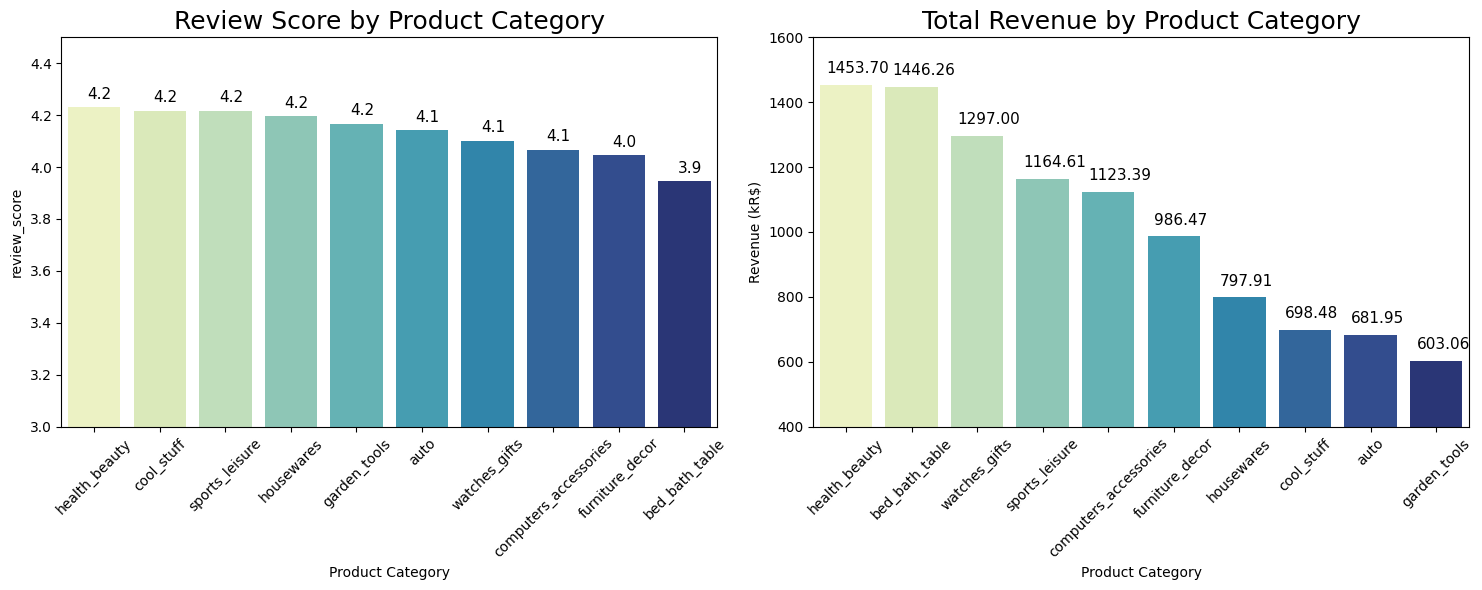

In [458]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

data = category_tb.sort_values('payment_value', ascending=False)
data['payment_value'] = data['payment_value']/1000
sns.barplot(data=data, x='product_category_name_english', y='payment_value', palette='YlGnBu', ax=ax[1], label='Revenue')
ax[1].set_title('Total Revenue by Product Category', fontsize=18)
ax[1].set_ylabel('Revenue (kR$)')
ax[1].set_xlabel('Product Category')
ax[1].set_ylim(400,1600)
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)
for i, v in enumerate(data['payment_value']):
    ax[1].text(i-0.3, v+50, f'{v:.2f}', color='black', fontsize=11, ha='left', va='center')

data = final_df.groupby('product_category_name_english')['review_score'].mean().reset_index().sort_values('review_score',ascending=False)
sns.barplot(data=data, x='product_category_name_english', y='review_score', palette='YlGnBu', ax=ax[0])
for i, v in enumerate(data['review_score']):
    ax[0].text(i-0.1,v+0.05, f'{v:.1f}', color='black', fontsize=11, ha='left', va='center')
ax[0].set_title('Review Score by Product Category', fontsize=18)
ax[0].set_xlabel('Product Category')
ax[0].set_ylim(3,4.5)
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

plt.tight_layout()
plt.show()


* "Health_Beauty" is the product category with the highest ratings in the top 10.
* It is also the product category with the highest revenue.

So let's see what customers are most concerned about?

In [481]:
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# Function to generate a word cloud visualization from text data
def generate_wordcloud(df, column_name):
    result_dict = {}
    stops = stopwords.words("english")
    porter = PorterStemmer()

    def clean_text(x):
        # Remove HTML
        raw = BeautifulSoup(x, "html.parser")
        raw = raw.get_text()
        # Remove non-alphabetic
        clean = re.sub("[^a-zA-Z]", " ", raw).lower()

        # Stem and remove stopwords
        clean = [porter.stem(word) for word in clean.split() if word not in stops]
        return " ".join(clean)

    df['clean_comment'] = df[column_name].apply(clean_text)

    def count_word(sentence):
        for word in sentence.split():
            if word not in result_dict:
                result_dict[word] = 1
            else:
                result_dict[word] += 1

    df['clean_comment'].apply(count_word)

    plt.figure(figsize=(15, 15))
    WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5, colormap="RdBu")

    # The syntax requires parameter as a body of text.
    text = ' '.join(df[df[column_name] != 'Unknown'][column_name].values)
    words = WC.generate(text)

    plt.imshow(words, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.show()



<ipython-input-481-92ba0f9bd57a>:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  raw = BeautifulSoup(x, "html.parser")


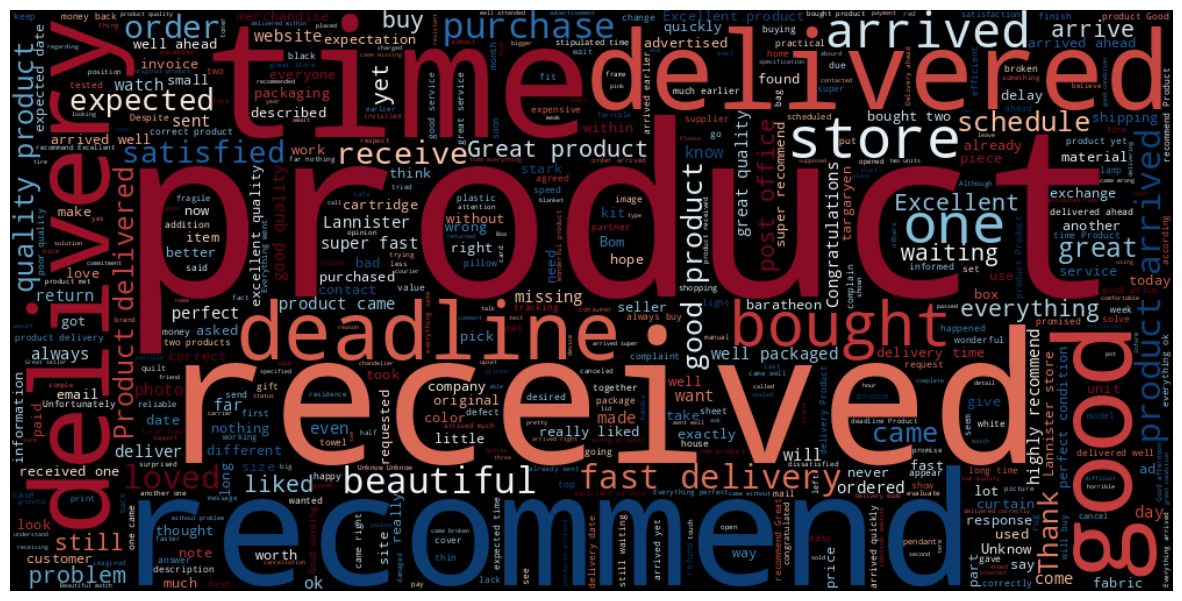

In [482]:
# Apply above function for eng_commnet columns
final_df['eng_comment'].fillna(value = 'Unknown', inplace = True)
generate_wordcloud(final_df, "eng_comment")

* The word cloud above was generated from customer review data.
* "Delivery service" is the most frequently appearing keyword.

###### Delivery service

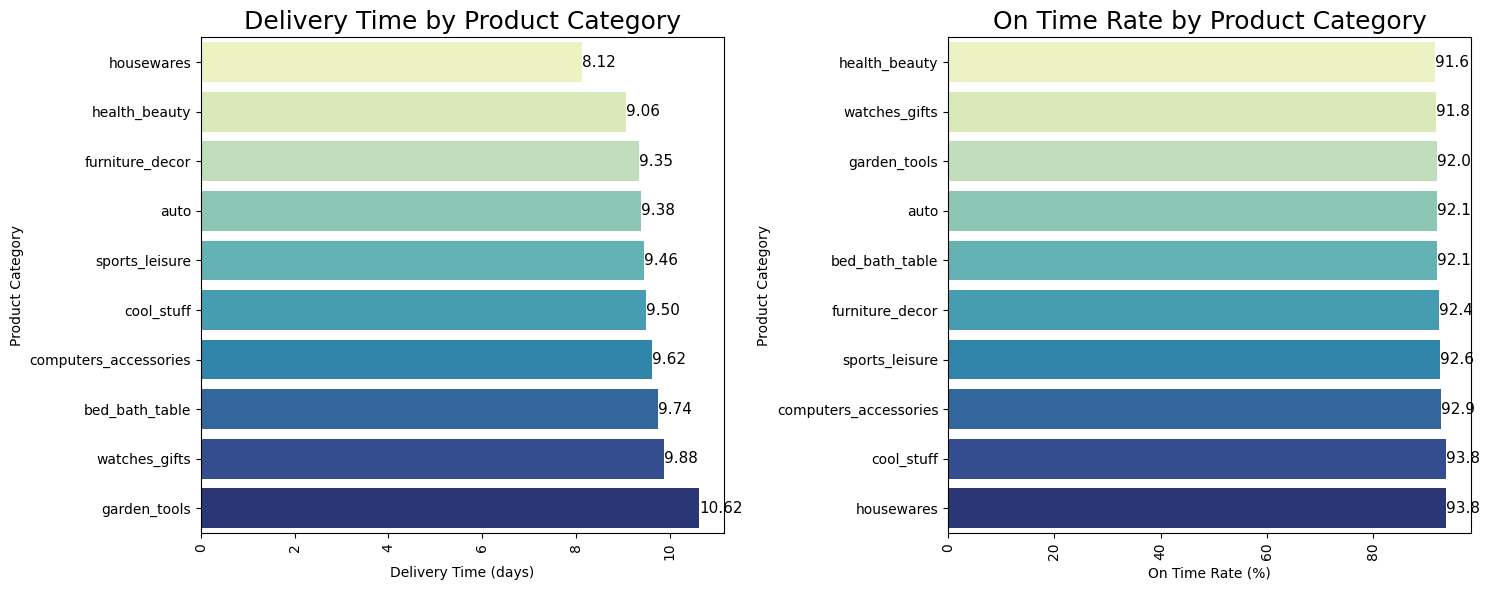

In [461]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))

data = final_df.groupby('product_category_name_english')['delivery_time_actual'].mean().reset_index().sort_values('delivery_time_actual')
sns.barplot(data=data, y='product_category_name_english', x='delivery_time_actual', ax=axes[0], palette='YlGnBu')
axes[0].set_title('Delivery Time by Product Category', fontsize=18)
axes[0].set_ylabel('Product Category')
axes[0].set_xlabel('Delivery Time (days)')
for tick in axes[0].get_xticklabels():
    tick.set_rotation(90)
for i,v in enumerate(data['delivery_time_actual']):
  axes[0].text(v,i,f'{v:.2f}',color='black',fontsize=11, ha='left', va='center')

data = final_df.groupby('product_category_name_english')['on_time_delivery'].mean().reset_index().sort_values('on_time_delivery')
data['on_time_delivery'] = data['on_time_delivery']*100
sns.barplot(data=data, y='product_category_name_english', x='on_time_delivery', palette='YlGnBu', ax=axes[1])
axes[1].set_title('On Time Rate by Product Category', fontsize=18)
axes[1].set_xlabel('On Time Rate (%)')
axes[1].set_ylabel('Product Category')
for i,v in enumerate(data['on_time_delivery']):
  axes[1].text(v,i,f'{v:.1f}',color='black',fontsize=11, ha='left', va='center')
for tick in axes[1].get_xticklabels():
    tick.set_rotation(90)

plt.tight_layout()
plt.show()


* Health_Beauty is doing well what customers care about with short delivery times and on-time delivery rate ~ 92%

From the above analysis, Health_beauty is the most potential product category for New Sellers with:
* Ranked in the top 20% of categories, accounting for 80% of total revenue
* Good customer reviews
* Satisfies customers' most important points: Delivery service with fast delivery speed and on-time rate ~ 92%.



In [462]:
# create new dataframe with product category only Health_Beauty
focus_df = final_df[final_df['product_category_name_english'].isin(['health_beauty'])]

##### Recommendations for New Sellers

###### Delivery service

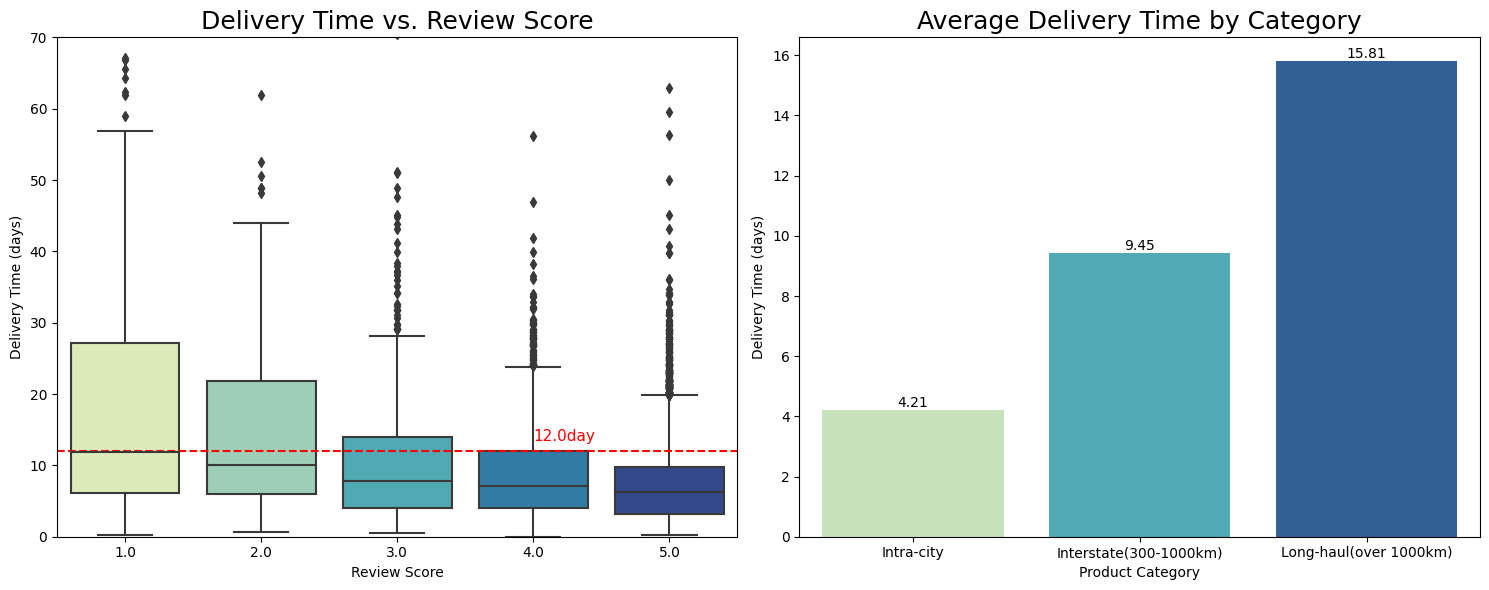

In [463]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

deli_revi_box = focus_df.groupby('distance_group')['delivery_time_actual'].mean().reset_index()
distance_group_labels = {
    1: 'Intra-city',
    2: 'Interstate(300-1000km)',
    3: 'Long-haul(over 1000km)'
}
deli_revi_box['distance_group'] = deli_revi_box['distance_group'].map(distance_group_labels)
sns.barplot(data=deli_revi_box, x='distance_group', y='delivery_time_actual', ax=axes[1], palette='YlGnBu')
axes[1].set_title('Average Delivery Time by Category', fontsize=18)
axes[1].set_xlabel('Product Category')
axes[1].set_ylabel('Delivery Time (days)')

for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=10)

sns.boxplot(data=focus_df, y='delivery_time_actual', x='review_score', palette='YlGnBu', ax=axes[0])
quantile_75 = focus_df[focus_df['review_score'] == 4]['delivery_time_actual'].quantile(0.75)
axes[0].axhline(y=quantile_75, color='red', linestyle='--', label='Quantile 0.75 (Review Score 4)')
axes[0].text(3, quantile_75 + 2, f'{quantile_75:.1f}day', color='red', fontsize=11, ha='left', va='center')
axes[0].set_title('Delivery Time vs. Review Score', fontsize=18)
axes[0].set_ylim(0,70)
axes[0].set_ylabel('Delivery Time (days)')
axes[0].set_xlabel('Review Score')

plt.tight_layout()

plt.show()

* The best delivery time is within 12 days. The majority of customers positively agree with this.
* The specific delivery times for different distances are 4.21, 9.45, and 15.81 days, respectively.

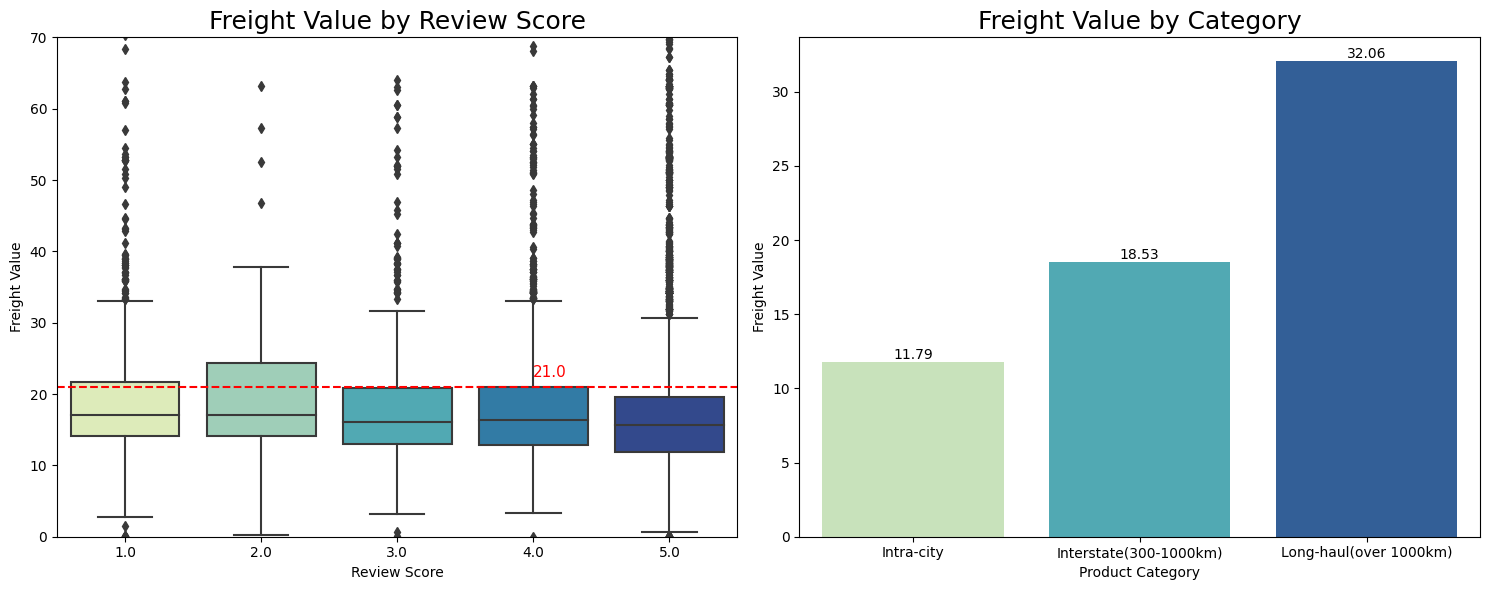

In [464]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

frei_revi_box = focus_df.groupby('distance_group')['freight_value'].mean().reset_index()
distance_group_labels = {
    1: 'Intra-city',
    2: 'Interstate(300-1000km)',
    3: 'Long-haul(over 1000km)'
}
frei_revi_box['distance_group'] = frei_revi_box['distance_group'].map(distance_group_labels)
sns.barplot(data=frei_revi_box, x='distance_group', y='freight_value', ax=axes[1], palette='YlGnBu')
axes[1].set_title('Freight Value by Category', fontsize=18)
axes[1].set_xlabel('Product Category')
axes[1].set_ylabel('Freight Value')

for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=10)

sns.boxplot(data=focus_df, y='freight_value', x='review_score', palette='YlGnBu', ax=axes[0])
quantile_75 = focus_df[focus_df['review_score'] == 4]['freight_value'].quantile(0.75)
axes[0].axhline(y=quantile_75, color='red', linestyle='--', label='Quantile 0.75 (Review Score 4)')
axes[0].text(3, quantile_75 + 2, f'{quantile_75:.1f}', color='red', fontsize=11, ha='left', va='center')
axes[0].set_title('Freight Value by Review Score', fontsize=18)
axes[0].set_ylim(0,70)
axes[0].set_ylabel('Freight Value')
axes[0].set_xlabel('Review Score')

plt.tight_layout()

plt.show()

* The delivery fee should be around 21R$.

  There is no significant difference in the delivery fee based on Review Score, indicating that the majority of customers agree with this fee.

* The delivery fee increases with each distance range, namely 11.79, 18.53, and 32.06, respectively.

###### Potential sales location

In [465]:
def brazil_map(df, colormap, cb_label):

    # receives a dataframe with data by country and makes a heat-world map based on the data

    # get geographical shape data
    brazil = gpd.read_file('/content/drive/MyDrive/Final Project/E-Commerce Olist/gadm41_BRA_1.json')
    brazil['HASC_1'] = brazil['HASC_1'].str.replace('BR.', '')
    # merge both datasets on country names

    data_merge = brazil.merge(df, left_on= 'HASC_1', right_on=df.columns[0])

    brazil['coords'] = brazil['geometry'].apply(lambda x: x.representative_point().coords[:])
    brazil['coords'] = [coords[0] for coords in brazil['coords']]

    # plot the base map with black lines
    base = brazil.plot(figsize=(10, 8), color='white', edgecolor='black', lw= 1, alpha=0.5)

    bbox_props = dict(boxstyle='round,pad=0.25', fc='white', ec='black')

    for idx, row in brazil.iterrows():
        base.text(s=row['HASC_1'], x=row['coords'][0]-1, y=row['coords'][1], horizontalalignment='center', bbox = bbox_props, fontsize=10)

    divider = make_axes_locatable(base)
    cax = divider.append_axes("right", size="2%", pad=0.1)

    # make the heatmap on top of base map
    data_merge.plot(ax=base, column= df.columns[-1], legend= True, cmap=colormap, cax= cax, legend_kwds= {'label': cb_label},aspect=1)

    base.axis('off')

    plt.savefig('/content/drive/MyDrive/Final Project/E-Commerce Olist/my_map.png',dpi=300)

<ipython-input-465-c5778bfa62aa>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  brazil['HASC_1'] = brazil['HASC_1'].str.replace('BR.', '')


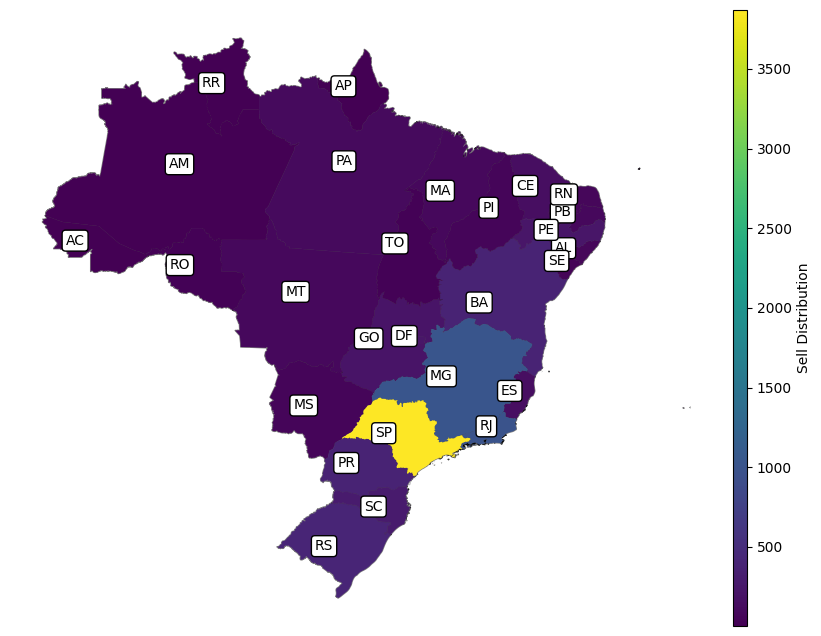

In [466]:
orde_sell_tb = focus_df.groupby('customer_state').agg({'order_id':'count','on_time_delivery':'mean','review_score':'mean'}).reset_index().sort_values('review_score')
orde_sell_tb
brazil_map(orde_sell_tb[['customer_state','order_id']],'viridis', 'Sell Distribution')

<ipython-input-465-c5778bfa62aa>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  brazil['HASC_1'] = brazil['HASC_1'].str.replace('BR.', '')


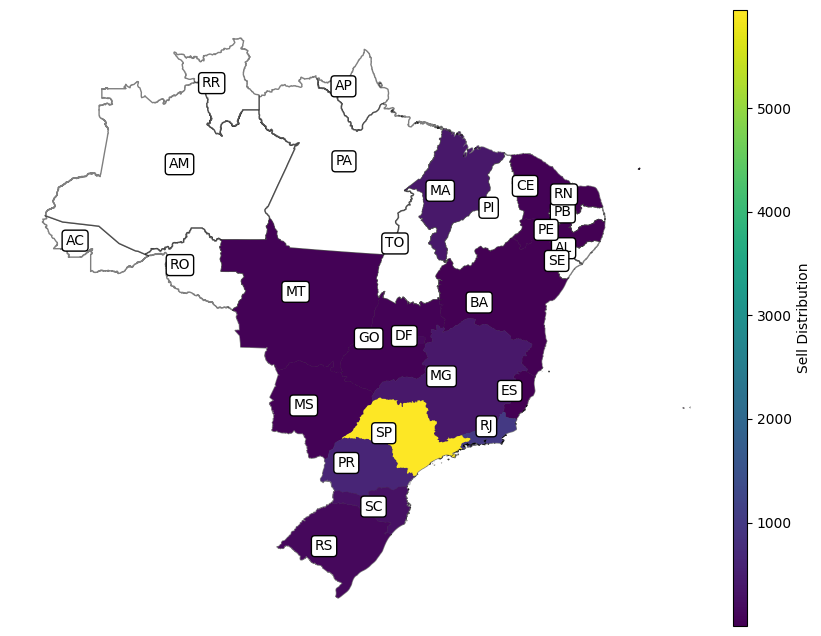

In [467]:
orde_sell_tb = focus_df.groupby('seller_state').agg({'order_id':'count','on_time_delivery':'mean','review_score':'mean'}).reset_index().sort_values('review_score')
orde_sell_tb
brazil_map(orde_sell_tb[['seller_state','order_id']],'viridis', 'Sell Distribution')

* Buyers and sellers are mainly concentrated in SP.

In [468]:
orde_state_tb = focus_df.groupby('customer_state').agg({'order_id':'count','on_time_delivery':'mean','review_score':'mean'}).reset_index().sort_values('review_score')
orde_state_tb

,customer_state,order_id,on_time_delivery,review_score
21,RR,4,0.500000,2.000000
1,AL,67,0.671642,3.641791
16,PI,50,0.800000,3.760000
26,TO,30,0.766667,3.800000
9,MA,84,0.714286,3.879518
5,CE,155,0.812903,3.883117
13,PA,107,0.859813,3.895238
4,BA,372,0.841398,3.913514
14,PB,82,0.890244,4.012195
12,MT,88,0.920455,4.034091


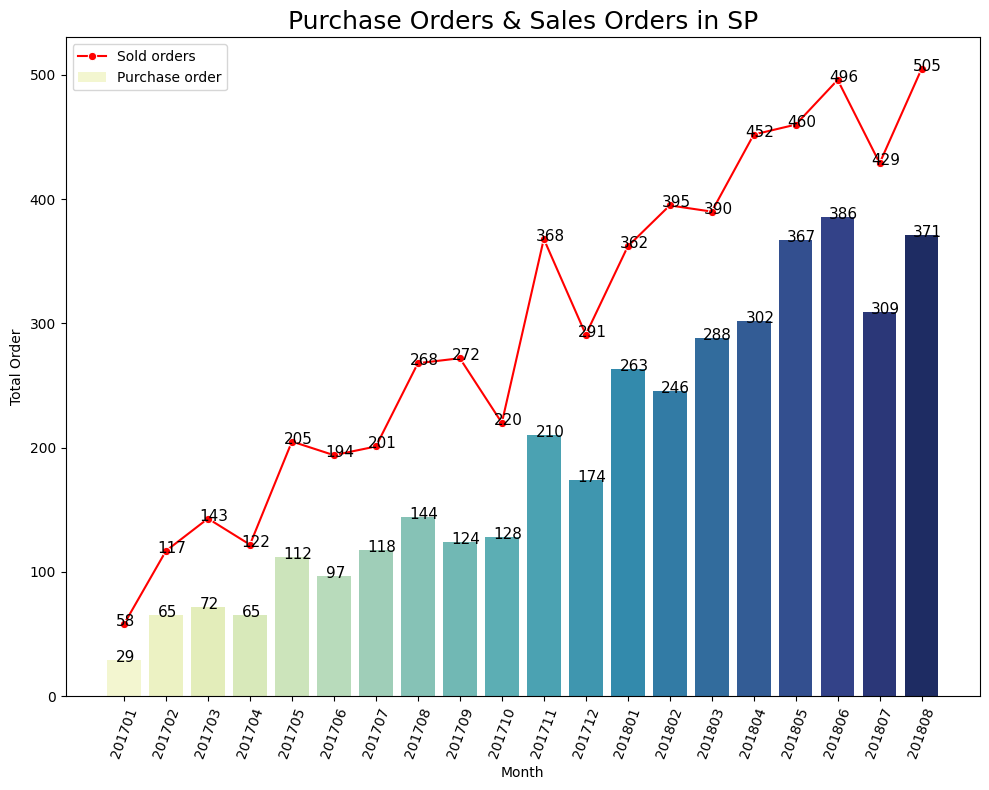

In [469]:
fig, ax = plt.subplots(figsize=(10,8))

cust_orde_tb = focus_df[focus_df['customer_state'].isin(['SP'])].groupby('order_purchase_year_month')['order_id'].count().reset_index()
sns.barplot(data=cust_orde_tb, x='order_purchase_year_month', y='order_id', ax=ax, palette='YlGnBu', label='Purchase order')
ax.set_xlabel('Month')
ax.set_ylabel('Total Order')
for tick in ax.get_xticklabels():
    tick.set_rotation(70)
for i, v in enumerate(cust_orde_tb['order_id']):
    ax.text(i-0.2, v+2, f'{v:.0f}', color='black', fontsize=11, ha='left', va='center')

sell_orde_tb = focus_df[focus_df['seller_state'].isin(['SP'])].groupby('order_purchase_year_month')['order_id'].count().reset_index()

all_months = pd.DataFrame({'order_purchase_year_month': [str(year) + str(month).zfill(2) for year in range(2017, 2019) for month in range(1, 13)]})
sell_orde_tb = all_months.merge(sell_orde_tb, on='order_purchase_year_month', how='left').fillna(0)
sell_orde_tb = sell_orde_tb.head(20)
sell_orde_tb

sns.lineplot(data=sell_orde_tb, x='order_purchase_year_month', y='order_id', ax=ax, color='red', marker='o', label='Sold orders')

# Thêm giá trị lên đường line
for i, v in enumerate(sell_orde_tb['order_id']):
    ax.text(i-0.2, v+2, f'{v:.0f}', color='black', fontsize=11, ha='left', va='center')

ax.set_title('Purchase Orders & Sales Orders in SP', fontsize=18)

# Thêm legend
ax.legend()

plt.tight_layout()
plt.show()


* However, currently supply has exceeded demand at SP,as shown by the number of Sold Orders far exceeding Purchased Orders.

  This will be a disadvantage for New Sellers if they start here.

In [470]:
seller_state_counts = focus_df.groupby('seller_state')['order_id'].count()
customer_state_counts = focus_df.groupby('customer_state')['order_id'].count()
seller_counts = focus_df.groupby('seller_state')['seller_id'].nunique()

state_order_df = pd.concat([seller_state_counts, customer_state_counts,seller_counts], axis=1)
state_order_df = state_order_df.reset_index()
state_order_df.columns = ['state','sold_orders', 'purchased_orders','total_seller']
state_order_df['total_seller'].fillna(value = 0, inplace = True)
state_order_df['sold_orders'].fillna(value = 0, inplace = True)
state_order_df['net_orders'] = state_order_df['purchased_orders'] - state_order_df['sold_orders']
state_order_df['potential_orders_per_seller'] = round(state_order_df['net_orders']/(state_order_df['total_seller']+1),0)
state_order_df.sort_values('potential_orders_per_seller',ascending=False,inplace=True)
state_order_df


,state,sold_orders,purchased_orders,total_seller,net_orders,potential_orders_per_seller
0,BA,13.0,372,2.0,359.0,120.0
9,PE,3.0,224,1.0,221.0,110.0
20,PA,0.0,107,0.0,107.0,107.0
21,PB,0.0,82,0.0,82.0,82.0
3,ES,10.0,153,1.0,143.0,72.0
17,AL,0.0,67,0.0,67.0,67.0
22,PI,0.0,50,0.0,50.0,50.0
1,CE,29.0,155,2.0,126.0,42.0
25,SE,0.0,38,0.0,38.0,38.0
12,RN,1.0,66,1.0,65.0,32.0


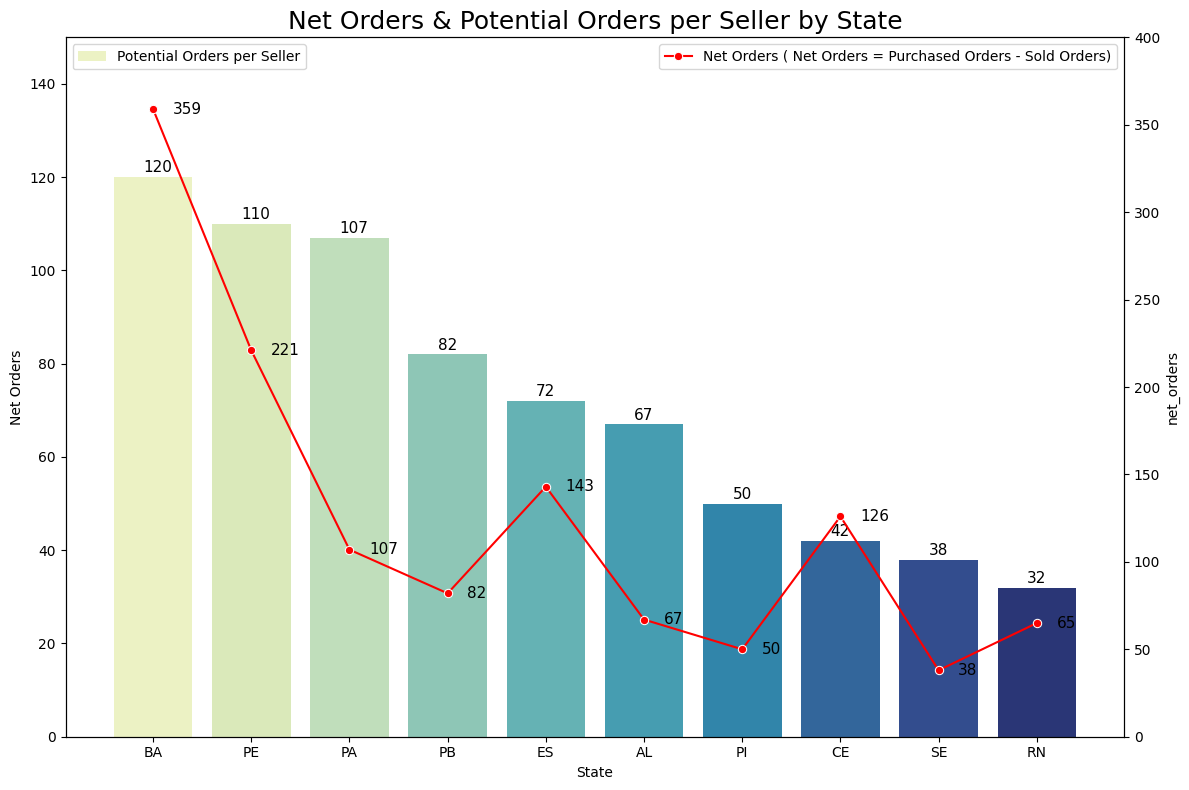

In [471]:
fig, ax = plt.subplots(figsize=(12,8))

sns.barplot(data=state_order_df.head(10), x='state', y='potential_orders_per_seller', ax=ax, palette='YlGnBu', label='Potential Orders per Seller')
ax.set_xlabel('State')
ax.set_ylim(0,150)
ax.set_ylabel('Potential Orders')
for i, v in enumerate(state_order_df['potential_orders_per_seller'].head(10)):
    ax.text(i-0.1, v+2, f'{v:.0f}', color='black', fontsize=11, ha='left', va='center')

ax1 = ax.twinx()
sns.lineplot(data=state_order_df.head(10), x='state', y='net_orders', ax=ax1, color='red', marker='o', label='Net Orders ( Net Orders = Purchased Orders - Sold Orders)')
ax.set_ylabel('Net Orders')
# Thêm giá trị lên đường line
for i, v in enumerate(state_order_df['net_orders'].head(10)):
    ax1.text(i+0.2, v, f'{v:.0f}', color='black', fontsize=11, ha='left', va='center')

ax.set_title('Net Orders & Potential Orders per Seller by State', fontsize=18)

# Thêm legend
ax.legend(loc='upper left')
ax1.legend(loc='upper right')
ax1.set_ylim(0,400)
plt.tight_layout()
plt.show()


According to the graph above, BA is the ideal location for New Seller because:
* Net Order is high, showing the number of Orders that Seller here has not been able to meet.
* Potential Orders per Seller is high, showing that the competition here is low.



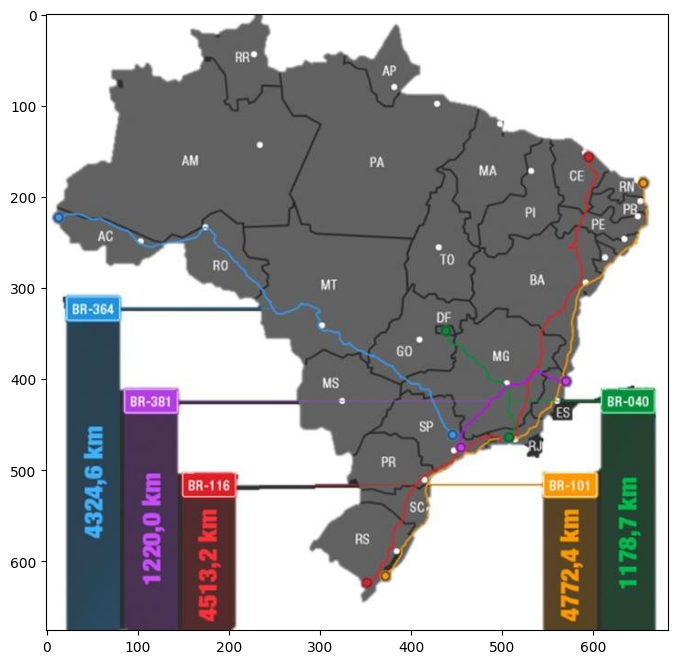

In [472]:
import matplotlib.image as mpimg
img = mpimg.imread("/content/drive/MyDrive/Final Project/E-Commerce Olist/The-main-highways-in-Brazil-and-its-length-based-on-3.png", format='jpeg')
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.show()


* Convenient transportation with 2 major highways passing through

In [473]:
data = {
    'state': ['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT', 'MS',
              'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO'],
    'population': [942123, 3407562, 904535, 4235555, 15128926, 8952013, 3204720, 46096, 7202463,
                   7206271, 3394102, 2880308, 21279353, 8639532, 4175326, 11623091, 9645321,
                   3341352, 17365809, 3619619, 11465252, 1837905, 708352, 7218704, 46302753,
                   2403563, 1692452],
    'GDP (USD)': [4263, 14819, 1827, 20909, 52171, 31871, 50547, 16367.89, 41006, 20706,
                  28826, 21721, 118349, 31668, 12180, 84651, 40803, 5278, 140679, 15428,
                  90132, 3857, 1624, 59479, 398692, 7714, 4263]
}

brazil_info = pd.DataFrame(data)
brazil_info.sort_values('population',ascending = False,inplace=True)
brazil_info

,state,population,GDP (USD)
24,SP,46302753,398692.00
12,MG,21279353,118349.00
18,RJ,17365809,140679.00
4,BA,15128926,52171.00
15,PR,11623091,84651.00
20,RS,11465252,90132.00
16,PE,9645321,40803.00
5,CE,8952013,31871.00
13,PA,8639532,31668.00
23,SC,7218704,59479.00


<ipython-input-465-c5778bfa62aa>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  brazil['HASC_1'] = brazil['HASC_1'].str.replace('BR.', '')


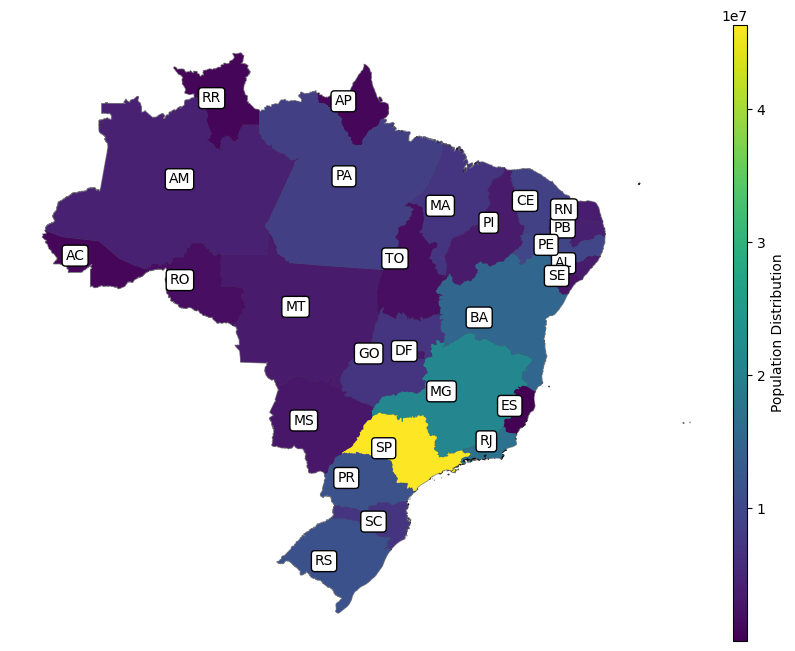

In [474]:
brazil_map(brazil_info[['state','population']],'viridis', 'Population Distribution')

* The population ranks in the top 4 states, the development potential is still very large

Other plus points: Solve the problem of Old Seller

<ipython-input-465-c5778bfa62aa>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  brazil['HASC_1'] = brazil['HASC_1'].str.replace('BR.', '')


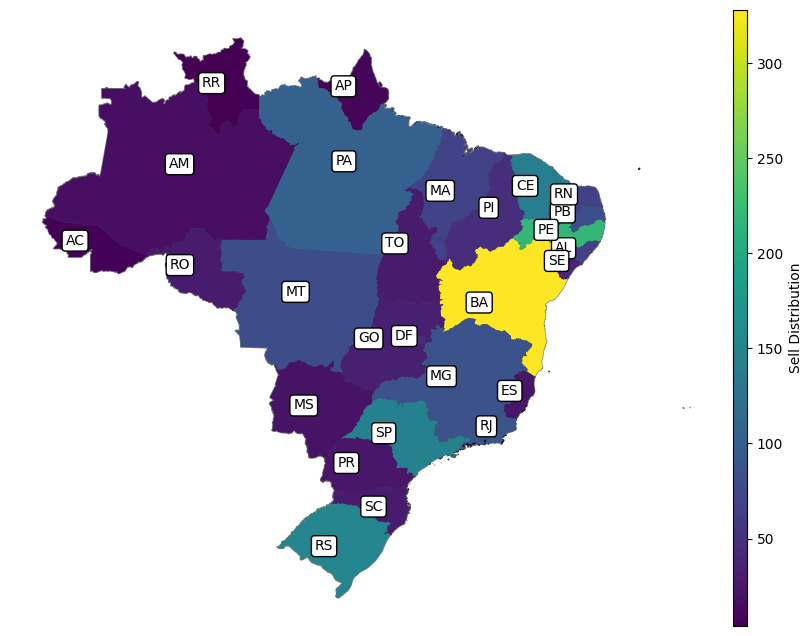

In [475]:
orde_sell_tb = focus_df[focus_df['distance_group']== 3].groupby('customer_state').agg({'order_id':'count','on_time_delivery':'mean','review_score':'mean'}).reset_index().sort_values('review_score')
orde_sell_tb
brazil_map(orde_sell_tb[['customer_state','order_id']],'viridis', 'Sell Distribution')

* BA is also a state with a large concentration of Long-haul orders.

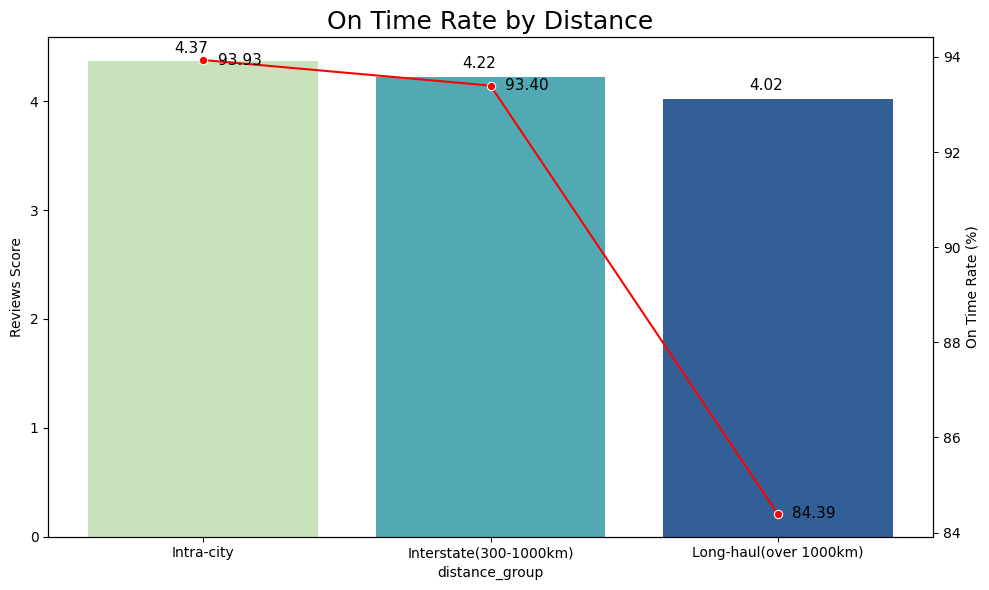

In [476]:
fig, ax1= plt.subplots(figsize=(10, 6))

dis_revi_box = focus_df.groupby('distance_group')['review_score'].mean().reset_index()
distance_group_labels = {
    1: 'Intra-city',
    2: 'Interstate(300-1000km)',
    3: 'Long-haul(over 1000km)'
}
dis_revi_box['distance_group'] = dis_revi_box['distance_group'].map(distance_group_labels)
sns.barplot(data=dis_revi_box , x='distance_group', y='review_score',ax=ax1,palette='YlGnBu')
ax1.set_ylabel('Reviews Score')
for i,v in enumerate(dis_revi_box['review_score']):
  ax1.text(i-0.1,v+0.12,f'{v:.2f}',color='black',fontsize=11, ha='left', va='center')

ax2 = ax1.twinx()

dis_onti_box = focus_df.groupby('distance_group')['on_time_delivery'].mean().reset_index()
distance_group_labels = {
    1: 'Intra-city',
    2: 'Interstate(300-1000km)',
    3: 'Long-haul(over 1000km)'
}
dis_onti_box['distance_group'] = dis_onti_box['distance_group'].map(distance_group_labels)
dis_onti_box['on_time_delivery'] = dis_onti_box['on_time_delivery']*100
sns.lineplot(data=dis_onti_box, x='distance_group', y='on_time_delivery', ax=ax2,color='red', marker='o' )
ax2.set_title('On Time Rate by Distance', fontsize=18)
ax2.set_xlabel('Distance')
ax2.set_ylabel('On Time Rate (%)')
for i,v in enumerate(dis_onti_box['on_time_delivery']):
  ax2.text(i+0.05,v,f'{v:.2f}',color='black',fontsize=11, ha='left', va='center')

plt.tight_layout()
plt.show()


* Long-haul is the current delivery distance that Old Sell is not doing well, shown by Review Score and On Time Rate, which are both clearly lower than the other two distances.

##### Conclutions

Priority Product Category Suggestion "Health_beauty" with :
* Ranked in the top 20% of categories, accounting for 80% of total revenue
* Good customer reviews (top 1)
* Satisfies customers' most important points: Delivery service with fast delivery speed ( ~ 9 days) and on-time rate ~ 92%.

Recommendations for New Sellers
* The best delivery time is within 12 days. The specific delivery times for different distances are 4.21, 9.45, and 15.81 days, respectively.
* The delivery fee should be around 21R$. The delivery fee increases with each distance range, namely 11.79, 18.53, and 32.06, respectively.
* BA is the ideal location for New Seller because:
  1. Net Order is high, showing the number of Orders that Seller here has not been

  2. Potential Orders per Seller is the best (120 orders/seller), showing that the competition here is low.
  3. Convenient transportation with 2 major highways passing through.
  4. The population ranks in the top 4 states, the development potential is still very large.
  5. Solve the problem of Old Seller : Long-haul delivery

In [477]:
# # Mount to Google Sheets
# from google.colab import auth
# auth.authenticate_user()

# # Import neccessary libraries -- Đi học syntax
# import gspread
# from google.auth import default
# creds, _ = default()
# from gspread_dataframe import set_with_dataframe

# # Authorize Google Sheets API
# gc = gspread.authorize(creds)

In [478]:
# # Create a new Google Spreadsheets
# sh = gc.create('Olist raw')

In [479]:
# def export_data_to_new_sheet(gsheet_key, worksheet_name, data):

#     sh = gc.open_by_key(gsheet_key)

#     # To create a new worksheet with 1000 rows and 26 columns
#     worksheet = sh.add_worksheet(worksheet_name, 1000, 26)

#     # For writing to an existing worksheet
#     # worksheet = sh.get_worksheet(0) # --> to get the first worksheet

#     set_with_dataframe(worksheet, data)

In [480]:
# export_data_to_new_sheet('11M5h2AplixtYPZicmjWlQp71CxZX5QWDF4QRVZv6Rlc','final_df',final_df)
# export_data_to_new_sheet('1FZGhzonK7A3fYtPJD6i76kvSjHGfNYt-Hp3xtiauXIs','Activity_ratio', Activity_ratio)
# export_data_to_new_sheet('1FZGhzonK7A3fYtPJD6i76kvSjHGfNYt-Hp3xtiauXIs','ML_company', ML_company)
# export_data_to_new_sheet('1FZGhzonK7A3fYtPJD6i76kvSjHGfNYt-Hp3xtiauXIs','ML_Ex_tb', ML_Ex_tb)
# export_data_to_new_sheet('1FZGhzonK7A3fYtPJD6i76kvSjHGfNYt-Hp3xtiauXIs','ML_framework', ML_framework)
# export_data_to_new_sheet('1FZGhzonK7A3fYtPJD6i76kvSjHGfNYt-Hp3xtiauXIs','CV', CV)
# export_data_to_new_sheet('1FZGhzonK7A3fYtPJD6i76kvSjHGfNYt-Hp3xtiauXIs','ML_algorithms', ML_algorithms)
# export_data_to_new_sheet('1FZGhzonK7A3fYtPJD6i76kvSjHGfNYt-Hp3xtiauXIs','NLP_methods', NLP_methods)
# export_data_to_new_sheet('1FZGhzonK7A3fYtPJD6i76kvSjHGfNYt-Hp3xtiauXIs','Auto_ML_tools', Auto_ML_tools)
# export_data_to_new_sheet('1FZGhzonK7A3fYtPJD6i76kvSjHGfNYt-Hp3xtiauXIs','Manage_ML', Manage_ML)